# load libraries

In [2]:
#install.packages()
library(R.matlab)
library(survival)
library(reticulate)

base.path <- '/home/haoqisun/Downloads/sleep-outcome-prediction/risk_calculator/'
source(file.path(base.path, 'Rfunctions.R'))

R.matlab v3.7.0 (2022-08-25 21:52:34 UTC) successfully loaded. See ?R.matlab for help.


Attaching package: ‘R.matlab’


The following objects are masked from ‘package:base’:

    getOption, isOpen




# specify which outcome to predict

In [3]:
outcome <- 'Dementia'

# load model

In [4]:
if (outcome=='Death') {
    model <- readRDS(file.path(base.path, sprintf('models/model_%s_CoxPH.rda', outcome)))
} else {
    model <- readRDS(file.path(base.path, sprintf('models/model_%s_CoxPH_CompetingRisk.rda', outcome)))
}

# load features

In [14]:
df <- read.csv(file.path(base.path, 'MGH_features_NREM.csv'))
idx <- 20
df <- df[idx,]

# z-transform features

In [15]:
preprossing.info <- read.csv(file.path(base.path, 'models', sprintf('preprocessing_%s.csv', outcome)))
cols <- preprossing.info$Name
Xmean <- preprossing.info$Mean
Xstd <- preprossing.info$Std
df[,cols] <- ( df[,cols]-t(replicate(nrow(df), Xmean)) ) / t(replicate(nrow(df), Xstd))
stopifnot(sum(is.na(df))==0)

# predict with trained model (survival package v3.2.13 works, but v3.5.7 does not work)

In [16]:
# the model has three elements:
pred1 <- summary(survfit(model[[1]], df))  # predict using model trained with frontal EEG
pred2 <- summary(survfit(model[[2]], df))  # predict using model trained with central EEG
pred3 <- summary(survfit(model[[3]], df))  # predict using model trained with occipital EEG

pred1 <- list(time=pred1$time, val=pred1$pstate, state=pred1$states)  # get the cumulative incidence curve (CIC)
pred2 <- list(time=pred2$time, val=pred2$pstate, state=pred2$states)
pred3 <- list(time=pred3$time, val=pred3$pstate, state=pred3$states)

pred <- harmonize.curves2(list(pred1, pred2, pred3)) # take average across multiple CICs
state.idx <- which(pred$states=='event1')
pred$val <- apply(pred$val, c(1,3,4), mean, na.rm=TRUE)[,,state.idx]

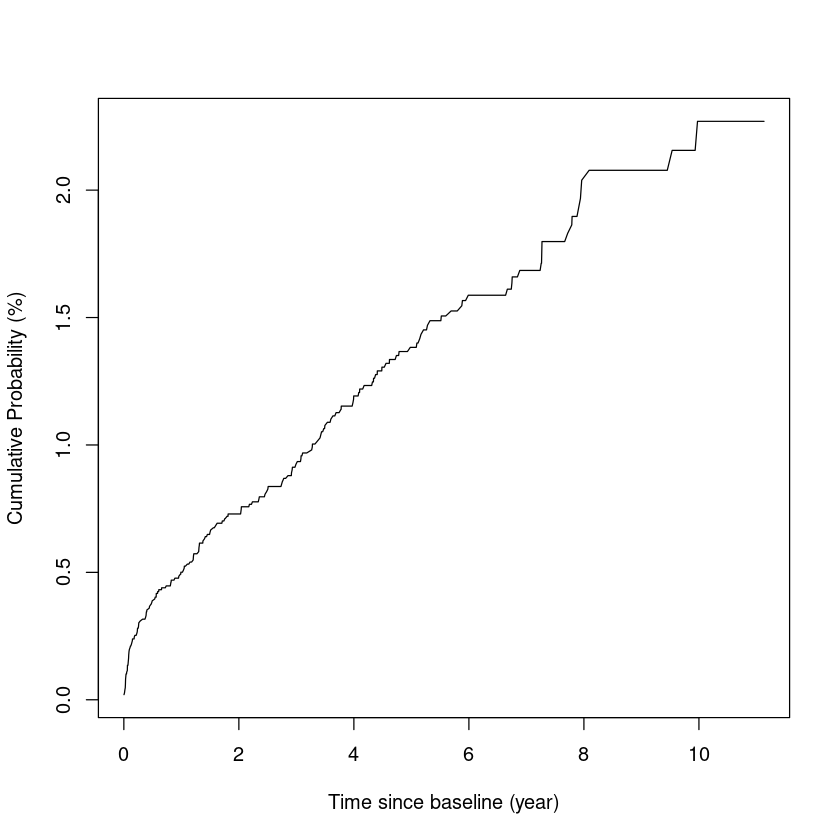

In [17]:
plot(
    pred$time, pred$val*100, type='l',
    xlab='Time since baseline (year)', ylab='Cumulative Probability (%)'
)